# Solutions for Lab Sheet 5 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-5-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling (uncomment if you want)
import numpy as np               # math

Let's download a wave file containing speech:

In [5]:
# download speech and noise example files
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  328k  100  328k    0     0  5953k      0 --:--:-- --:--:-- --:--:-- 6090k


As done before several time by now, we can load it to a variable and play it back (if we like).

In [6]:
import soundfile as sf
from IPython import display as ipd

# load speech wave into variable
s, fs = sf.read(s_file_name)

print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

File "speech_8kHz_murder.wav" loaded. Its sampling rate is 8000 Hz.


## Spectrogram (Task 1)

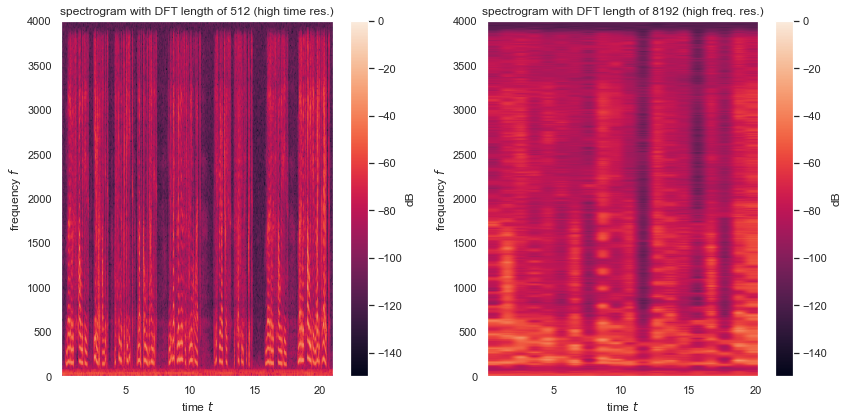

In [14]:
# visualise
fig=plt.figure(figsize=(12,6)) # create a figure of size 12 x 6 inches

LDFT=512

plt.subplot(1,2,1)
plt.specgram(s, Fs=fs, NFFT=LDFT); # NFFT default: 256
plt.title('spectrogram with DFT length of ' + str(LDFT) + ' (high time res.)')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None) # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-150,0)


LDFT=8192

plt.subplot(1,2,2)
plt.specgram(s, Fs=fs, NFFT=LDFT); # NFFT default: 256
plt.title('spectrogram with DFT length of ' + str(LDFT) + ' (high freq. res.)')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None)  # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-150,0)

plt.tight_layout()